In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.spatial.distance import correlation as dcorrelation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix

sns.set(style="white")
%matplotlib inline

In [158]:
class Scaler:
    
    def __init__(self):
        self._mu = 0
        self._std = 0
    
    def fit(self, x):
        self._mu = np.mean(x)
        self._std = np.std(x)
    
    def transform(self, x):
        y = np.copy(x)
        return (y - self._mu) / self._std
    
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)
    
    def inverse(self, x):
        y = np.copy(x)
        return (y * self._std) + self._mu
    
    def __repr__(self):
        return f"{self._mu}, {self._std}"
    

class Normalizer:
    
    def __init__(self):
        self._min = 0
        self._max = 0
    
    def fit(self, x):
        self._min = np.min(x)
        self._max = np.max(x)
    
    def transform(self, x):
        y = np.copy(x)
        return (y - self._min) / (self._max - self._min)

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)
    
    def inverse(self, x):
        y = np.copy(x)
        return (y * (self._max - self._min)) + self._min 
        
    def __repr__(self):
        return f"{self._min}, {self._max}"   
    
    
class LinearRegressionImpl:
    
    def __init__(self, fit_intercept=True, reg=1e-20, weights=None):
        self.w = weights
        self.fit_intercept = fit_intercept
        self._reg = reg
    
    def mse(self, y, yh):
        N = y.shape[0]
        L2 = (self._reg / (2 * N)) * np.sum([np.sum(np.square(w)) for w in self.w])
        return ((1 / N) * np.sum(np.square(y - yh))) + L2
    
    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def train(self, X, y):
        X = self._add_intercept(X)
        
        pinv = np.dot(X.T, X)
        reg = np.eye(pinv.shape[0], dtype=int) * self._reg
        reg[0][0] = 1
        nX = np.dot(np.linalg.inv(pinv + reg), X.T)
        self.w = np.dot(nX, y)
        
        yh = np.dot(X, self.w)
        J = self.mse(y, yh)
        return self, J
    
    def predict(self, X):
        X = self._add_intercept(X)
        return np.dot(X, self.w)


class LogisticRegressionImpl():
        
    def __init__(self, fit_intercept=True, reg=1e-20, weights=None):
        self.w = weights
        self.fit_intercept = fit_intercept
        self._reg = reg
    
    def __sigmoid(self, z):
        return 1./(1 + np.exp(-z))
    
    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def train(self, x, y, lr=1e-4, epochs=10000):
        x = self._add_intercept(x)
        self.N = y.size
        if self.w is None:
            self.w = np.random.rand(x.shape[1], ) * np.sqrt(2 / (self.N + 2))
        J = []
        for i in range(epochs):
            # Forward
            yh = self.__sigmoid(np.dot(x, self.w))
            # Gradient
            dw = (1 / self.N) * np.dot(x.T, (yh - y))
            # Weight adjust
            self.w = (self.w - (lr * dw)) - (((lr * self._reg) / self.N) * self.w)
            # Loss
            loss = self.__loss(y, yh)
            J.append(np.round(loss, 5))
        return self, J

    def predict_proba(self, x):
        x = self._add_intercept(x)
        return self.__sigmoid(np.dot(x, self.w))
    
    def predict(self, x, threshold=0.5):
        return (self.predict_proba(x) >= threshold).astype(np.int)
    
    def __loss(self, y, yh):
        L2 = (self._reg / (2 * self.N)) * np.sum([np.sum(np.square(w)) for w in self.w])
        bce = -np.sum(np.multiply(y, np.log(yh)) + np.multiply((1-y), np.log(1 - yh)))
        return ((1 / self.N) * bce) + L2

# IA006 - Exercícios de Fixação de Conceitos

$~$

## EFC2 - 2s2019

$~$

### Parte 1 - Classificação Binária

$~$

**Problema:** identificação dogênero do locutor apartir de trechos de voz

**Dataset:** https://www.mldata.io/dataset-details/gender_voice/

Descrição dos dados:

| Name | Type | Description |
|------|------|-------------|
| meanfreq | float | mean frequency (in kHz) |
| sd | float | standard deviation of frequency |
| median | float | median frequency (in kHz) |
| Q25 | float | first quantile (in kHz) |
| Q75 | float | third quantile (in kHz) |
| IQR | float | interquantile range (in kHz) |
| skew | float | skewness (see note in specprop description) |
| kurt | float | kurtosis (see note in specprop description) |
| sp.ent | float | spectral entropy |
| sfm | float | spectral flatness |
| mode | float | mode frequency |
| centroid | float | frequency centroid (see specprop) |
| meanfun | float | average of fundamental frequency measured across acoustic signal |
| minfun | float | minimum fundamental frequency measured across acoustic signal |
| label | string | Predictor class, male or female |

Apresentação dos 5 primeiros dados:

In [226]:
df = pd.read_csv("dados_voz_genero.csv")
print(df.head(5))

   Unnamed: 0        sd    median       Q25       Q75       IQR       skew  \
0           0  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1           1  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2           2  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3           3  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4           4  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812

**a)** Análise estatística dos dados

A análise será feita nos dados que tem relação direta com dados de audio, que são: *skew, kurt, sp.ent, sfm, mode, centroid*.

In [227]:
sound_c = df[["sd", "median", "skew", "kurt", "sp.ent", "sfm", "mode", "centroid", "label"]]

In [228]:
data = []
for field in ["sd", "median", "skew", "kurt", "sp.ent", "sfm", "mode", "centroid"]:
    unique_elements, counts_elements = np.unique(sound_c[field], return_counts=True)
    data.append([
        field,
        len(sound_c[field]),
        np.round(np.min(sound_c[field]), 3),
        np.round(np.max(sound_c[field]), 3),
        np.round(np.mean(sound_c[field]), 3),
        np.round(np.median(sound_c[field]), 3),
        np.round(np.var(sound_c[field]), 3),
        np.round(np.std(sound_c[field]), 3),
        len(counts_elements)
    ])
df2 = pd.DataFrame(data, columns=["Field", "Qtd", "Min", "Max", "Mean", "Median", "Var.", "Std", "Unique"])
print(df2)

      Field   Qtd    Min       Max    Mean  Median       Var.      Std  Unique
0        sd  3168  0.018     0.115   0.057   0.059      0.000    0.017    3166
1    median  3168  0.011     0.261   0.186   0.190      0.001    0.036    3077
2      skew  3168  0.142    34.725   3.140   2.197     17.976    4.240    3166
3      kurt  3168  2.068  1309.613  36.568   8.318  18199.997  134.907    3166
4    sp.ent  3168  0.739     0.982   0.895   0.902      0.002    0.045    3166
5       sfm  3168  0.037     0.843   0.408   0.396      0.032    0.177    3166
6      mode  3168  0.000     0.280   0.165   0.187      0.006    0.077    2825
7  centroid  3168  0.039     0.251   0.181   0.185      0.001    0.030    3166


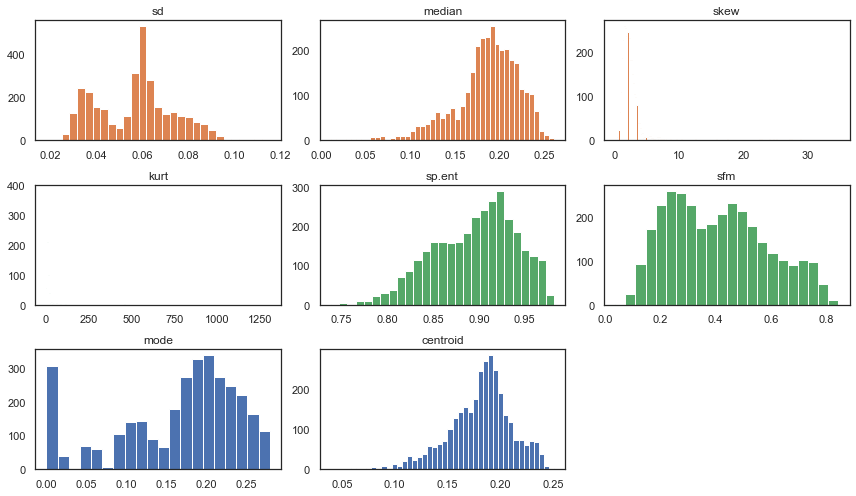

In [229]:
plt.figure(figsize=(12, 7))
plt.subplot(3, 3, 1)
plt.title("sd")
plt.hist(sound_c["sd"], bins='auto', color="C1")
plt.subplot(3, 3, 2)
plt.title("median")
plt.hist(sound_c["median"], bins='auto', color="C1")
plt.subplot(3, 3, 3)
plt.title("skew")
plt.hist(sound_c["skew"], bins='auto', color="C1")
plt.subplot(3, 3, 4)
plt.title("kurt")
plt.hist(sound_c["kurt"], bins='auto', color="C2")
plt.subplot(3, 3, 5)
plt.title("sp.ent")
plt.hist(sound_c["sp.ent"], bins='auto', color="C2")
plt.subplot(3, 3, 6)
plt.title("sfm")
plt.hist(sound_c["sfm"], bins='auto', color="C2")
plt.subplot(3, 3, 7)
plt.title("mode")
plt.hist(sound_c["mode"], bins='auto')
plt.subplot(3, 3, 8)
plt.title("centroid")
plt.hist(sound_c["centroid"], bins='auto')
plt.tight_layout()
plt.show()

Como é possível observar alguns dos atributos tem seu histograma próximo ao formato de uma distribuição gaussiana. Abaixo, são apresentados as Densidades de Probabilidade dos mesmos dados, entretanto escalonados usado a seguinte operação:

$y = \frac{x-\mu}{\sigma}$

In [230]:
scaler = Scaler()
sound_c.loc[:]["sd"] = scaler.fit_transform(sound_c["sd"])
sound_c.loc[:]["median"] = scaler.fit_transform(sound_c["median"])
sound_c.loc[:]["skew"] = scaler.fit_transform(sound_c["skew"])
sound_c.loc[:]["kurt"] = scaler.fit_transform(sound_c["kurt"])
sound_c.loc[:]["sp.ent"] = scaler.fit_transform(sound_c["sp.ent"])
sound_c.loc[:]["sfm"] = scaler.fit_transform(sound_c["sfm"])
sound_c.loc[:]["mode"] = scaler.fit_transform(sound_c["mode"])
sound_c.loc[:]["centroid"] = scaler.fit_transform(sound_c["centroid"])

In [231]:
data = []
for field in ["sd", "median", "skew", "kurt", "sp.ent", "sfm", "mode", "centroid"]:
    unique_elements, counts_elements = np.unique(sound_c[field], return_counts=True)
    data.append([
        field,
        len(sound_c[field]),
        np.round(np.min(sound_c[field]), 5),
        np.round(np.max(sound_c[field]), 5),
        np.round(np.mean(sound_c[field]), 5),
        np.round(np.median(sound_c[field]), 5),
        np.round(np.var(sound_c[field]), 5),
        np.round(np.std(sound_c[field]), 5),
        len(counts_elements)
    ])
df2 = pd.DataFrame(data, columns=["Field", "Qtd", "Min", "Max", "Mean", "Median", "Var.", "Std", "Unique"])
print(df2)

      Field   Qtd      Min      Max  Mean   Median  Var.  Std  Unique
0        sd  3168 -2.32814  3.49241  -0.0  0.12187   1.0  1.0    3166
1    median  3168 -4.80399  2.07963  -0.0  0.12135   1.0  1.0    3077
2      skew  3168 -0.70720  7.44961  -0.0 -0.22243   1.0  1.0    3166
3      kurt  3168 -0.25573  9.43643   0.0 -0.20940   1.0  1.0    3166
4    sp.ent  3168 -3.47939  1.93162   0.0  0.14764   1.0  1.0    3166
5       sfm  3168 -2.09214  2.44922   0.0 -0.06694   1.0  1.0    3166
6      mode  3168 -2.14121  1.48616   0.0  0.27616   1.0  1.0    2825
7  centroid  3168 -4.73181  2.34737  -0.0  0.13144   1.0  1.0    3166


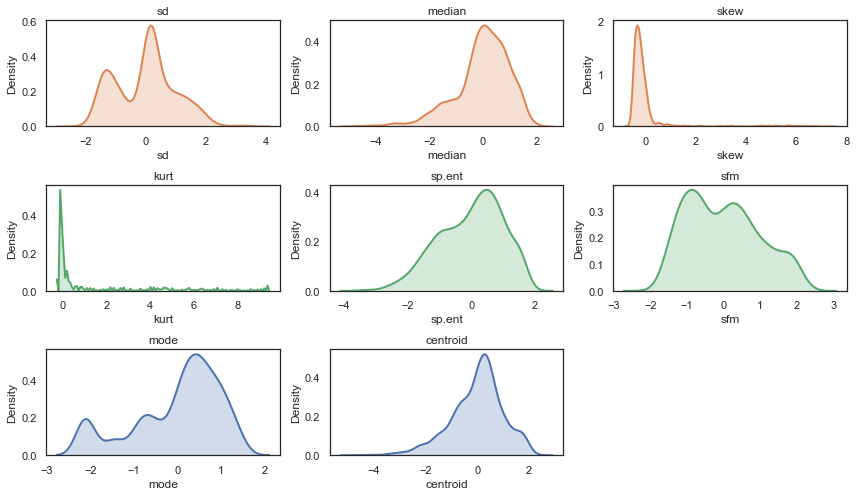

In [232]:
kds = {'shade': True, 'linewidth': 2}

plt.figure(figsize=(12, 7))
plt.subplot(3, 3, 1)
plt.title("sd")
sns.distplot(sound_c["sd"], hist=False, kde=True, kde_kws=kds, color="C1")
plt.ylabel('Density')
plt.subplot(3, 3, 2)
plt.title("median")
sns.distplot(sound_c["median"], hist=False, kde=True, kde_kws=kds, color="C1")
plt.ylabel('Density')
plt.subplot(3, 3, 3)
plt.title("skew")
sns.distplot(sound_c["skew"], hist=False, kde=True, kde_kws=kds, color="C1")
plt.ylabel('Density')
plt.subplot(3, 3, 4)
plt.title("kurt")
sns.distplot(sound_c["kurt"], hist=False, kde=True, kde_kws=kds, color="C2")
plt.ylabel('Density')
plt.subplot(3, 3, 5)
plt.title("sp.ent")
sns.distplot(sound_c["sp.ent"], hist=False, kde=True, kde_kws=kds, color="C2")
plt.ylabel('Density')
plt.subplot(3, 3, 6)
plt.title("sfm")
sns.distplot(sound_c["sfm"], hist=False, kde=True, kde_kws=kds, color="C2")
plt.ylabel('Density')
plt.subplot(3, 3, 7)
plt.title("mode")
sns.distplot(sound_c["mode"], hist=False, kde=True, kde_kws=kds)
plt.ylabel('Density')
plt.subplot(3, 3, 8)
plt.title("centroid")
sns.distplot(sound_c["centroid"], hist=False, kde=True, kde_kws=kds)
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Através da matriz de correlação, podemos ter uma ideia de como as features de nosso dataset estão correlacionadas entre si.

Nota-se uma correlação relativamente alta entre os campos *sfm* e *centroid*. E mais fraca entre todos os outros campos.

Evitando, encontrar apenas correlações lineares entres os valores, aplica-se também a Correlação em Distância, a qual possibilita visualizar valores de correlação não lineares entre variáveis e também avaliar a indepedência das variáveis (quando o valor for zero).

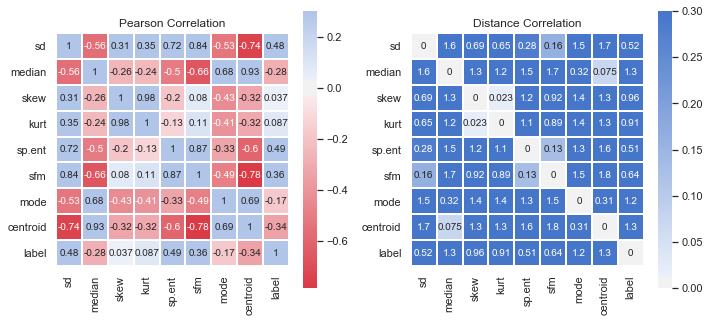

In [233]:
corr = sound_c.corr()
fields = ["sd", "median", "skew", "kurt", "sp.ent", "sfm", "mode", "centroid", "label"]

dcorr = np.zeros((9, 9))
for i, field in enumerate(fields):
    for k, field2 in enumerate(fields):
        dcorr[i][k] = dcorrelation(sound_c[field], sound_c[field2])

cmap = sns.diverging_palette(10, 255, as_cmap=True)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title("Pearson Correlation")
ax = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, annot=True, cbar_kws={"shrink": .5})
ax.set_ylim(9, 0)
plt.subplot(1, 2, 2)
plt.title("Distance Correlation")
ax = sns.heatmap(dcorr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, annot=True, cbar_kws={"shrink": .5},
            xticklabels=fields, yticklabels=fields
)
ax.set_ylim(9, 0)
plt.tight_layout()
plt.show()

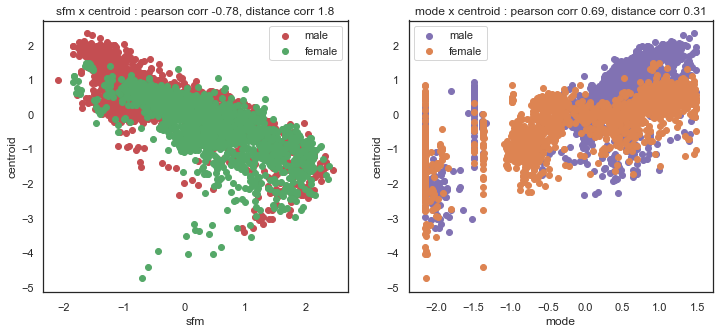

In [234]:
labels, colors, colors2 = ("male", "female"), ("C3", "C2"), ("C4", "C1")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, color, label in zip([0, 1], colors, labels):
    sfm = sound_c[sound_c["label"] == i]["sfm"]
    centroid = sound_c[sound_c["label"] == i]["centroid"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("sfm x centroid : pearson corr -0.78, distance corr 1.8")
plt.xlabel("sfm")
plt.ylabel("centroid")
plt.legend()
plt.subplot(1, 2, 2)
for i, color, label in zip([0, 1], colors2, labels):
    sfm = sound_c[sound_c["label"] == i]["mode"]
    centroid = sound_c[sound_c["label"] == i]["centroid"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("mode x centroid : pearson corr 0.69, distance corr 0.31")
plt.xlabel("mode")
plt.ylabel("centroid")
plt.legend()
plt.show()

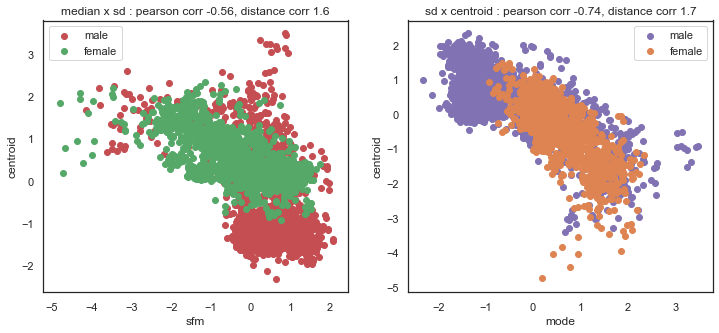

In [235]:
labels, colors, colors2 = ("male", "female"), ("C3", "C2"), ("C4", "C1")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, color, label in zip([0, 1], colors, labels):
    sfm = sound_c[sound_c["label"] == i]["median"]
    centroid = sound_c[sound_c["label"] == i]["sd"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("median x sd : pearson corr -0.56, distance corr 1.6")
plt.xlabel("sfm")
plt.ylabel("centroid")
plt.legend()
plt.subplot(1, 2, 2)
for i, color, label in zip([0, 1], colors2, labels):
    sfm = sound_c[sound_c["label"] == i]["sd"]
    centroid = sound_c[sound_c["label"] == i]["centroid"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("sd x centroid : pearson corr -0.74, distance corr 1.7")
plt.xlabel("mode")
plt.ylabel("centroid")
plt.legend()
plt.show()

De acordo com a análise estatística apresentada acima, podemos usar apenas os seguintes campos do dataset para conseguir uma acurácia em torno de 78% (*sd*, *median*, *sp.ent, sfm, centroid*).

Outros campos analisados como *skew* e *kurt*, tem baixa correlação com o label final e o campo *mode* tem uma forte correlação com todos os outros campos mas também relativamente baixa com o label.

Dessa maneira, os testes apresentados na resposta do exercício B usam apenas os campos descritos acima (*sd*, *median*, *sp.ent, sfm, centroid*).

**b)** Implementar a Regressão Logística e apresentar os valores da curva ROC e F1-Score em função do threshold.

O modelo de Regressão Logística implementado possui 4 hiperparâmetros, que devem ser preenchidos em determinados momentos, são eles:

 - Regularização => valor padrão : 1e-20
 - Learning rate => valor padrão : 1e-4
 - Épocas do algoritmo de GD => valor padrão : 10000
 - Threshold de classificação => valor padrão : 0.5
 
Nos testes iniciais o único valor padrão alterado foi de learning rate, alterado de 1e-4 para 1e-2, para que o modelo possa convergir no melhor ponto dentro da quantidade de épocas padrão. Neste algoritmo não foi implementado Early Stop.

In [241]:
fields = ["sd", "median", "sp.ent", "sfm", "centroid"]
x = sound_c[fields]
y = sound_c["label"]
# Adicionado para processo de train test split
data = np.c_[x, y]
size = data.shape[0]
# 20%
train_split = int((size * 20) / 100)
# Embaralhar
permutation = np.random.permutation(size)
data = data[permutation, :]
# Train test split
fsize = len(fields)
x_train = data[train_split:, :fsize]
y_train = data[train_split:, fsize:].ravel()
x_test = data[:train_split, :fsize]
y_test = data[:train_split, fsize:].ravel()

# Logistic function
clf = LogisticRegressionImpl()
_, J = clf.train(x_train, y_train, lr=1e-2)

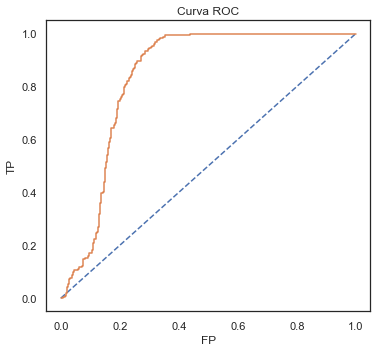

In [242]:
probs = clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Curva ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel("FP")
plt.ylabel("TP")
plt.tight_layout()
plt.show()

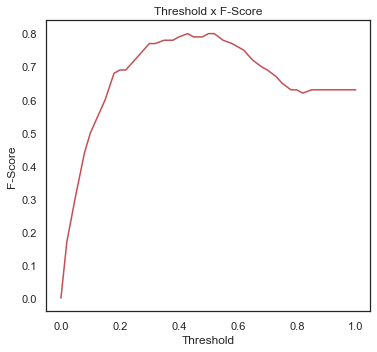

Resultados:
------------------------------
    Threshold  Acurácia  Erros  Recall  Precisão  F-Score
17       0.43     83.73  16.27    0.96      0.68     0.80
20       0.50     82.78  17.22    0.88      0.73     0.80
21       0.52     82.46  17.54    0.86      0.74     0.80
16       0.40     83.57  16.43    0.96      0.67     0.79
18       0.45     83.10  16.90    0.93      0.69     0.79
19       0.48     83.10  16.90    0.90      0.71     0.79
14       0.35     83.41  16.59    0.98      0.65     0.78
15       0.38     83.25  16.75    0.97      0.65     0.78
22       0.55     80.88  19.12    0.81      0.76     0.78
13       0.32     82.94  17.06    0.99      0.63     0.77


In [243]:
def calculate_resultados(y_test, y_pred):
    with np.errstate(all='ignore'):
        cfm = confusion_matrix(y_test, y_pred)
        acertos = cfm[0, 0] + cfm[1, 1]
        erros = cfm[0, 1] + cfm[1, 0]
        precisao = np.round(cfm[0, 0] / (cfm[0, 0] + cfm[0, 1]), 2)
        recall = np.round(cfm[0, 0] / (cfm[0, 0] + cfm[1, 0]), 2)
        fscore = np.round((2 * recall * precisao) / (recall + precisao), 2)
        acuracia = np.round(acertos / len(y_test) * 100, 2)
        erros = np.round(erros / len(y_test) * 100, 2)
    return acuracia, erros, recall, precisao, fscore
    
def print_resultados(acuracia, erros, recall, precisao, fscore):
    print("Acurácia:")
    print("-" * 30)
    print(f"Acertos: {acuracia}%")
    print(f"Erros  : {erros}%")
    print()
    print("Recall | Precisão | F-Score")
    print("-" * 30)
    print(f"{recall}   | {precisao}     | {fscore}")


resultados = []
for thre in np.linspace(0, 1, 41):
    thre = np.round(thre, 2)
    y_pred = clf.predict(x_test, threshold=thre)
    resultados.append(np.concatenate((np.array([thre]), calculate_resultados(y_test, y_pred))))
resultados = np.nan_to_num(np.array(resultados))

df = pd.DataFrame(resultados, columns=["Threshold", "Acurácia", "Erros", "Recall", "Precisão", "F-Score"])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Threshold x F-Score")
plt.plot(df["Threshold"], df["F-Score"], c="C3")
plt.xlabel("Threshold")
plt.ylabel("F-Score")
plt.tight_layout()
plt.show()

ordered = df.sort_values(by=["F-Score", "Acurácia"], ascending=False)

print("Resultados:")
print("-" * 30)
print(ordered.head(10))

Como é possível observar a curva ROC e a evolução da métrica F-Score indicam que o melhor threshold é em torno de ~$0.40$ até ~$0.65$, com variação no F-Score.

**c)** Melhor valor do threshold e matriz de confusão dos resultados.

Conforme visto acima, o resultado do melhor F-Score ficou em torno de ~0.4 até ~0.65.

Abaixo será aplicado o melhor de threshold encontrado e observado na tabela acima.

Melhor threshold encontrado usando os experimentos acima: 0.43

Acurácia:
------------------------------
Acertos: 83.73%
Erros  : 16.27%

Recall | Precisão | F-Score
------------------------------
0.96   | 0.68     | 0.8


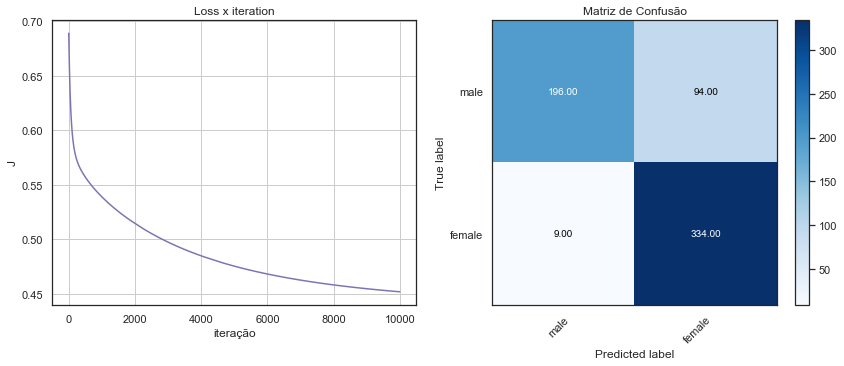

In [245]:
best_threshold = ordered["Threshold"].to_numpy()[0]
print(f"Melhor threshold encontrado usando os experimentos acima: {best_threshold}")
print()

y_pred = clf.predict(x_test, threshold=best_threshold)
print_resultados(*calculate_resultados(y_test, y_pred))

cfm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Loss x iteration")
plt.xlabel("iteração")
plt.ylabel("J")
plt.plot(J, color="C4")
plt.grid(True)
ax = plt.subplot(1, 2, 2)

im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=["male", "female"], yticklabels=["male", "female"],
       title="Matriz de Confusão",
       ylabel='True label',
       xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)
plt.tight_layout()
plt.show()

Após a análise exploratória dos dados e a verificação de qual o melhor threshold do classificador de Regressão Logística é possível notar a relativa precisão do classificador permitindo que o mesmo tenha um bom grau de generalização mesmo nos dados de teste. Dito isto a análise exploratória e mesmo a escolha das features e hiperparâmetros podem influenciar na melhor ou pior generalização do modelo.

### Parte 2 - Classificação Multi Classe

$~$

**Problema:** identificação de atividade humana usando dados de smartphones

**Dataset:** https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones